In [2]:
# %pylab inline
import json
import numpy as np
# import seaborn as sns
# sns.set_context('paper')
# import pandas as pd
# import matplotlib as mpl
from string import atof
%pylab inline
from matplotlib.font_manager import FontProperties
from cartopy import crs
from cartopy.io.img_tiles import OSM,StamenTerrain,GoogleTiles
from scipy.interpolate import griddata
from tqdm import tqdm_notebook as tqdm
font0 = FontProperties()
font0.set_family('serif')
font0.set_name('ubuntu')
class StamenToner(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://tile.stamen.com/toner/{}/{}/{}.png'.format(z, x, y)
        return url

class cyclemap(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://b.tile.opencyclemap.org/cycle/{}/{}/{}.png'.format(z, x, y)
        return url

class hillshading(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://c.tiles.wmflabs.org/hillshading/{}/{}/{}.png'.format(z, x, y)
        return url
    

# imagery = OSM()
imagery = StamenToner()
# imagery =cyclemap()
# imagery = hillshading()

PC=crs.PlateCarree()
target = imagery.crs

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
    
def haversine(la1,lo1,la2,lo2):
    """
        haversine function (https://en.wikipedia.org/wiki/Haversine_formula)
        for the distance between two points on a sphere of radius R
        earth radius approximated to 6371 Km, accuracy of 0.5% (wikipedia)
    """
    EARTH_RADIUS = 6371 #Km
    C = np.cos
    S = np.sin
    lo1,la1,lo2,la2 = map(np.radians,(lo1,la1,lo2,la2))
    dlat = la2-la1
    dlon = lo2-lo1
    h2   = (S(dlat/2.)**2.+C(la1)*C(la2)*S(dlon/2.)**2.)**.5
    return 2.*EARTH_RADIUS*np.arcsin(h2) # in km

def draw_points_circle_lat_long(R,center,minll,maxll,N,exact=200,Rmin=0):
    """ Draw N points in a circle of radius R"""
    x,y=minll
    X,Y=maxll
    x0,y0 = center
    
    out = [X,Y]-np.random.rand(N,2)*[X-x,Y-y]
    la1,lo1 = out.T
    hd = haversine(la1,lo1,x0,y0) 
    within_radius = ((hd > Rmin) & (hd < R) )
    out = out[within_radius]
    
    n = out.shape[0]
    
    if n<N and exact:
        out_2 = draw_points_circle_lat_long(R,center,minll,maxll,int(1.1*(N-n)),exact=exact-1,Rmin=Rm)[:N-n]
        out = np.r_[out,out_2]
    return out #[[lat,lon],[lat,lon],...]

In [4]:
extent = [(48.76569416599118, 2.00775146484375),
 (48.946406107750576, 2.6772308349609375)]

In [6]:
# for radius in [4000,5000,10000]:
#     c2 = CircleMarker(location=m.center)
#     #, radius=radius, weight=2,
#      #       color='#F00', opacity=1, fill_opacity=1,
#       #      fill_color='#F00')
#     m.add_layer(c2)
#     c2.visible=True

# Checking that the sampling is reasonable

In [7]:
import pandas as pd
from scipy.spatial import cKDTree as kd


In [8]:
def dist_p2p(i,j,toTree):
    la1,lo1 = toTree.T[i]
    la2,lo2 = toTree.T[j]
    return haversine(la1,lo1,la2,lo2)

def get_neighbors(fin,what):
    real = pd.read_pickle(fin)
    stuff = real[(real.kind=='full') & (real['mode']=='bicycling')][['p1','p2']]

    toTree = set([ (i,j) for i,j in stuff[what].values])
    toTree = np.asarray(list(toTree)).T
    toTree_merc = target.transform_points(PC,toTree[1],toTree[0])
    tree = kd(data=toTree_merc)
    neighbors = tree.query(toTree_merc,k=6)[1]
    distances = []
    for i,nn in enumerate(neighbors):
        distances.extend([dist_p2p(i,j,toTree) for j in nn if i!=j])
    return distances

In [11]:
D = 10. # km
dL = 0.1 #km
D**2/dL**2 # nr of cells to cover a square of 10km di side with cells of 100m of side

9999.999999999998

In [19]:
def plot_map(what,ax,c='r',s=1):#,cx,color,lw=.75):
    
    lats=[]
    lons=[]
    
    PC=crs.PlateCarree()
    target = imagery.crs
    for point in tqdm(what):
        
        lat,lon = point
        lon_merc,lat_merc,_ = target.transform_points(PC,np.asarray(lon),np.asarray(lat)).T
        ax.plot(lon_merc,lat_merc,'ob',color=c,mew=0,ms=s)
        lats.extend(lat_merc)
        lons.extend(lon_merc)
    
    ax.add_image(imagery, 12)
#     ax.add_image(hillshadin, 12)
    
    minLAm=float(np.min(lats))
    minLOm=float(np.min(lons))
    maxLAm=float(np.max(lats))
    maxLOm=float(np.max(lons))
    
    minLA,minLO = PC.transform_point(minLOm,minLAm,target)
    maxLA,maxLO = PC.transform_point(maxLOm,maxLAm,target)
    ax.set_extent((minLA,maxLA,minLO,maxLO))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
#     return (minLA,maxLA,minLO,maxLO),bins    

HBox(children=(IntProgress(value=0, max=8832), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8945), HTML(value=u'')))

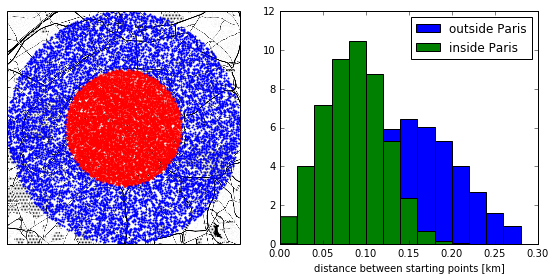

In [28]:
def get_p1(fin,what):
    real = pd.read_pickle(fin)
    stuff = real[(real.kind=='full') & (real['mode']=='bicycling')][what]

    out = set([ (i,j) for i,j in stuff.values])
    out = np.asarray(list(out))
    return out


# x0,y0=center
# x,X =x0-1e-2*9,x0+1e-2*9
# y,Y =y0-2e-2*7,y0+2e-2*7
# R = haversine(x0,y0,X,y0)
# print R

# RMs = [5,10]
# Rms = [0,5.]
fins = ['../data/outin_latest.pdpkl','../data/inside_latest.pdpkl'][::-1]
cs  = ['#FF0000','#0000FF']
names = ['inside','outside']


scale = 4
fig = plt.figure(figsize=(2*scale,1*scale))
ax = plt.subplot(121,projection=imagery.crs)
bx = plt.subplot(122)
# fig, (ax,bx) = plt.subplots(1,2,figsize=(1*scale,2*scale),subplot_kw=dict(projection=imagery.crs))

for fin,c,name in zip(fins,cs,names):
    points = get_p1(fin,'p1')
    plot_map(points,ax,c=c,s=2)

distances = get_neighbors('../data/outin_latest.pdpkl','p1')
bx.hist(distances,bins=np.arange(0,0.30,0.02),normed=1,label='outside Paris');
distances = get_neighbors('../data/inside_latest.pdpkl','p1')
bx.hist(distances,bins=np.arange(0,0.30,0.02),normed=1,label='inside Paris');
bx.set_xlabel('distance between starting points [km]')
bx.legend(loc='best')
fig.tight_layout()

fig.savefig('../plots/average_distance.png',dpi=96,bbox_inches='tight')